# Data Pre-Processing Notebook
This notebook contains the data processing for the project's F1 Kaggle datasets.

In [542]:
#Import general pytohn packages
import pandas as pd
import numpy as np

#Modelling packages
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, PowerTransformer, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import statsmodels.api as sm

from scipy.stats import jarque_bera, normaltest

#Import Python packages prepared for this project
from workflowpackages.data import get_kaggle_f1_data
#-------------------------
#For complete code regarding the package see 'workflowpackages' .py files
#You can also type ? and ?? after the imported function to see documentation and full source code in-line
#-------------------------

In [506]:
get_kaggle_f1_data(force_download=False)

No missing datasets. The following datasets are available:
- circuits.csv
- constructors.csv
- lap_times.csv
- races.csv
- sprint_results.csv
- constructor_results.csv
- driver_standings.csv
- pit_stops.csv
- results.csv
- status.csv
- constructor_standings.csv
- drivers.csv
- qualifying.csv
- seasons.csv


In [507]:
#READ DATA
#Read the dataframes from the source and label them
df_results = pd.read_csv('datasets/f1/results.csv')
df_races = pd.read_csv('datasets/f1/races.csv')
df_drivers = pd.read_csv('datasets/f1/drivers.csv')
df_driver_standings = pd.read_csv('datasets/f1/driver_standings.csv')
#--------------------------------------------------

#SELECT COLUMNS
#Select columns to keep for modelling in the dataframes
#Results data
results_cols = [
    'resultId', #Unique id for a race result per driver
    'raceId',
    'driverId',
    'grid',
    'position', #Numeric, null if position text is R, D, or W - meaning the car was retired, disqualified, or withdrawn
    'positionText' #String, same as position, instead of null, indicates R, D, or W
]
#Races data
races_cols = [
    'raceId',
    'year',
    'date',
    'circuitId',
    'round'
]
#Drviers data
drivers_cols = [
    'driverId',
    'dob' #Driver code based on driver last name
]
#Drvier standings data
driver_standings_cols = [
    'driverStandingsId',
    'raceId',
    'driverId',
    'points' #Cum sum of points in the season
]
#---------------------------------------------------

#FILTER DATA
#Filter the dataframes by selected columns
df_results = df_results[results_cols]
df_races = df_races[races_cols]
df_drivers = df_drivers[drivers_cols]
#---------------------------------------------------

#JOIN THE DATA
#Join the races data to results dataframe
df_model = df_results.merge(
    df_races,
    how = 'inner',
    on = 'raceId',
)
#Join the drivers data to results dataframe
df_model = df_model.merge(
    df_drivers,
    how = 'inner',
    on = 'driverId',
)
#-------------------------------------------------

In [508]:
#Filter races to analyze (limit historical period)
mask = (df_model['year'] >= 2000) & (df_model['year'] != 2024)
df_model = df_model[mask]

In [509]:
#---------------------------------------------------
#FEATURE ENGINEERING
#---------------------------------------------------

#---------------------------------------------------
#DICOTOMIC FEATURES : CREATE DUMMY VARIABLES
#---------------------------------------------------

#Get dummies for Finished Race
dummies_finished = pd.get_dummies(
    #Modify positionText column to indicate "finished_race" if the car finished the race, otherwise "out"
    df_model['positionText'].apply(lambda x: 'finished_race' if str.isnumeric(x) else 'Out'),
    prefix = 'Car'
).drop(
    ['Car_finished_race'],
    axis = 1
)
#Join dummies to model dataset
df_model = df_model.merge(
    dummies_finished,
    how = 'inner',
    left_index = True,
    right_index = True
).drop(
    ['positionText'],
    axis = 1
)
#---------------------------------------------------

#Get dummies for Driver id
dummies_drivers = pd.get_dummies(
    df_model['driverId'],
    prefix = 'Driver'
)
#Join dummies to model dataset
df_model = df_model.merge(
    dummies_drivers,
    how = 'inner',
    left_index = True,
    right_index = True
)
#---------------------------------------------------

#Get dummies for season
dummies_season = pd.get_dummies(
    df_model['year'],
    prefix = 'Season'
)
#Join dummies to model dataset
df_model = df_model.merge(
    dummies_season,
    how = 'inner',
    left_index = True,
    right_index = True
)
#---------------------------------------------------

#---------------------------------------------------
#DRIVER FEATURES
#---------------------------------------------------

#DRIVERS AGE
#Change to datetime
df_model['dob'] = pd.to_datetime(df_model['dob'])
df_model['date'] = pd.to_datetime(df_model['date'])

#Calculate the age in years at the time of the race
df_model['DriverAge'] = (df_model['date'] - df_model['dob']) / pd.Timedelta(days=365.25)
#---------------------------------------------------

#DRIVER YEARS OF F1 EXPERIENCE
#Calculate the min date (race date) by driver in the dataframe and join
df_model = df_model.merge(
    pd.pivot_table(
        df_model,
        index = 'driverId',
        values = 'date',
        aggfunc = 'min'
    ).reset_index().rename(columns = {'date':'DriverVintage'}),
    how = 'inner',
    on = 'driverId'
)
#Calculate the years of experience at the time of the race
df_model['DriverExpYears'] = (df_model['date'] - df_model['DriverVintage']) / pd.Timedelta(days=365.25)
#---------------------------------------------------

#---------------------------------------------------
#RESULTS FEATURES
#---------------------------------------------------

#OTHER DRIVERS STARTING POSITION IN THE GRID
#Grid as float
df_model['grid'] = df_model['grid'].astype('float')

#Calculate a column per driver per race with their grid position
race_driver_grid = pd.pivot_table(
    df_model,
    index = 'raceId',
    columns = 'driverId',
    values = 'grid',
    aggfunc = 'max'
).fillna(0)

#Get column names, append Driver as prefix and Grid as suffix to column names
race_driver_gid_cols = {}
for x in race_driver_grid.columns:
    race_driver_gid_cols[x] = 'Driver' + str(x) + '_Grid'
    
#Rename columns
race_driver_grid = race_driver_grid.rename(columns=race_driver_gid_cols)

#Merge with original dataframe
df_model = df_model.merge(
    race_driver_grid,
    how = 'inner',
    on = 'raceId'
)
#---------------------------------------------------

#DRIVER POSITION IN PREVIOUS RACES IN A GIVEN SEASON

#Change position to float
df_model['position'] = df_model['position'].apply(lambda x : 0 if x == '\\N' else x).astype('float')

#Pivot the data to create a matrix of results by year by driver
df_pivot = df_model.pivot_table(
    index=['driverId', 'year','resultId'],
    columns='round', 
    values='position',
    aggfunc='max',
    fill_value=None
)

#Forward fill pivot table by rows
df_pivot = df_pivot.groupby(['driverId', 'year'],group_keys=False).apply(lambda x: x.ffill(axis=0)).fillna(0)

#Rename columns
df_pivot_prevraces_cols = {}
for x in df_pivot.columns:
    df_pivot_prevraces_cols[x] = 'Pos_R'+str(x)
    
df_pivot = df_pivot.rename(columns=df_pivot_prevraces_cols)

#merge with original dataframe
df_model = df_model.merge(
    df_pivot,
    how = 'inner',
    on = 'resultId'
)
#---------------------------------------------------

#DRIVERS RESULTS IN THE PREVIOUS 5 SEASONS BY POINTS

#Join the driver standings data to race dataframe
df_driver_standings = df_driver_standings.merge(
    df_races[['raceId','year','round']],
    how = 'inner',
    on = 'raceId',
)

#Create a pivot table that summarizes driver results per season
df_pivot = df_driver_standings.pivot_table(
    index = ['year','driverId'],
    values = 'points',
    aggfunc = 'max'
).reset_index().sort_values(
    by=['driverId', 'year'], 
    ascending=[True, False]
).sort_values(
    by=['driverId', 'year'],
    ascending=[True,True]
)

# Create lagged points columns for the previous five years results
df_pivot_past5seasons_cols = []
for i in range(1, 6):
    df_pivot[f'points_{i}_years_ago'] = df_pivot.groupby('driverId')['points'].shift(i).fillna(0)

    #Store column names for later use
    df_pivot_past5seasons_cols.append(f'points_{i}_years_ago')

#Merge with main dataframe
# Assuming 'results' is the name of your other dataframe
df_model = df_model.merge(
    df_pivot, 
    on=['driverId', 'year'], 
    how='left'
).fillna(0)
#---------------------------------------------------

#---------------------------------------------------
#CLEAN REMMAINING DATA COLUMNS
#---------------------------------------------------
#Clean nulls and change datatypes

#Change to float
df_model['circuitId'] = df_model['circuitId'].astype('float')
#---------------------------------------------------

In [510]:

#Save model in csv
df_model.to_csv('outputs/processed_dataframe.csv')
#---------------------------------------------------

In [511]:
df_model

,resultId,raceId,driverId,grid,position,year,date,circuitId,round,dob,...,Pos_R19,Pos_R20,Pos_R21,Pos_R22,points,points_1_years_ago,points_2_years_ago,points_3_years_ago,points_4_years_ago,points_5_years_ago
0,1,18,1,1.0,1.0,2008,2008-03-16,1.0,1,1985-01-07,...,0.0,0.0,0.0,0.0,98.0,109.0,0.0,0.0,0.0,0.0
1,2,18,2,5.0,2.0,2008,2008-03-16,1.0,1,1977-05-10,...,0.0,0.0,0.0,0.0,60.0,61.0,23.0,28.0,3.0,6.0
2,3,18,3,7.0,3.0,2008,2008-03-16,1.0,1,1985-06-27,...,0.0,0.0,0.0,0.0,17.0,20.0,4.0,0.0,0.0,0.0
3,4,18,4,11.0,4.0,2008,2008-03-16,1.0,1,1981-07-29,...,0.0,0.0,0.0,0.0,61.0,109.0,134.0,133.0,59.0,55.0
4,5,18,5,3.0,5.0,2008,2008-03-16,1.0,1,1981-10-19,...,0.0,0.0,0.0,0.0,53.0,30.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9595,3049,163,55,17.0,9.0,2000,2000-05-21,20.0,6,1964-06-11,...,0.0,0.0,0.0,0.0,0.0,2.0,9.0,36.0,47.0,42.0
9596,3042,163,57,3.0,2.0,2000,2000-05-21,20.0,6,1968-09-28,...,0.0,0.0,0.0,0.0,89.0,76.0,100.0,27.0,31.0,17.0
9597,3048,163,60,21.0,8.0,2000,2000-05-21,20.0,6,1975-05-08,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9598,3047,163,64,15.0,7.0,2000,2000-05-21,20.0,6,1970-05-22,...,0.0,0.0,0.0,0.0,0.0,3.0,3.0,2.0,2.0,0.0


In [512]:
#MODELLING

#Feature Selection
#Define model dataset

#List continious columns, useful for standard scaler later in the code
model_cont_cols = [
    #'grid', # is excluded if the Driver Grid variables are included, since one of them per driver is equal to the grid
    'round',
    'circuitId',
    'DriverAge',
    'DriverExpYears'
]
#Append Other Drivers Position in Starting Grid variables, not in previous list
for x in race_driver_gid_cols.values():
    model_cont_cols.append(x)

#Append Driver's prior results in the season, not in previous list
for x in df_pivot_prevraces_cols.values():
    model_cont_cols.append(x)   

#Append Driver's prior results in the past 5 seasons by total points, not in previous list
for x in df_pivot_past5seasons_cols:
    model_cont_cols.append(x) 

#Append continious variables to column list
model_cols = []
for x in model_cont_cols:
    model_cols.append(x)

#Append Finished Dummies, not in previous list excluding last Dummy Variable to avoid perfect multicolinearity
if len(dummies_finished.columns[:len(dummies_finished.columns)]) == 1:
    model_cols.append(dummies_finished.columns[0])
else:
    for x in dummies_finished.columns[:len(dummies_finished.columns) -1]:
        model_cols.append(x)
    
#Append Driver Dummies, not in previous list excluding last Dummy Variable to avoid perfect multicolinearity
for x in dummies_drivers.columns[:len(dummies_drivers.columns) -1]:
    model_cols.append(x)
    
#Append Season Dummies, not in previous list excluding last Dummy Variable to avoid perfect multicolinearity
for x in dummies_season.columns[:len(dummies_season.columns) -1]:
    model_cols.append(x)
#---------------------------------------------------

#Train and Test Split
X_train, X_test, y_train, y_test = train_test_split(
    df_model[model_cols].astype(float), 
    df_model['position'].astype(float),
    test_size = 0.3,
    random_state = 37 #Because 37 is a fantabulous number
)
#----------------------------------------------------

In [513]:

#Check Dataset info
X_train.info()
#----------------------------------------------------

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6720 entries, 1769 to 1935
Columns: 300 entries, round to Season_2022
dtypes: float64(300)
memory usage: 15.4 MB


In [514]:

#Check Dataset columns
X_train.info()
#----------------------------------------------------

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6720 entries, 1769 to 1935
Columns: 300 entries, round to Season_2022
dtypes: float64(300)
memory usage: 15.4 MB


In [515]:

#Preview model dataset columns
print('Columns in dataset: ')
for x in X_train.columns:
    print('--> ' + x)
#----------------------------------------------------

Columns in dataset: 
--> round
--> circuitId
--> DriverAge
--> DriverExpYears
--> Driver1_Grid
--> Driver2_Grid
--> Driver3_Grid
--> Driver4_Grid
--> Driver5_Grid
--> Driver6_Grid
--> Driver7_Grid
--> Driver8_Grid
--> Driver9_Grid
--> Driver10_Grid
--> Driver11_Grid
--> Driver12_Grid
--> Driver13_Grid
--> Driver14_Grid
--> Driver15_Grid
--> Driver16_Grid
--> Driver17_Grid
--> Driver18_Grid
--> Driver19_Grid
--> Driver20_Grid
--> Driver21_Grid
--> Driver22_Grid
--> Driver23_Grid
--> Driver24_Grid
--> Driver25_Grid
--> Driver26_Grid
--> Driver27_Grid
--> Driver28_Grid
--> Driver29_Grid
--> Driver30_Grid
--> Driver31_Grid
--> Driver32_Grid
--> Driver33_Grid
--> Driver34_Grid
--> Driver35_Grid
--> Driver36_Grid
--> Driver37_Grid
--> Driver38_Grid
--> Driver39_Grid
--> Driver40_Grid
--> Driver41_Grid
--> Driver42_Grid
--> Driver43_Grid
--> Driver44_Grid
--> Driver45_Grid
--> Driver46_Grid
--> Driver47_Grid
--> Driver48_Grid
--> Driver49_Grid
--> Driver50_Grid
--> Driver51_Grid
--> Driver52_

In [516]:

#Preview model dataset continious columns
print('Continious columns in dataset: ')
for x in model_cont_cols:
    print('--> ' + x)
#----------------------------------------------------

Continious columns in dataset: 
--> round
--> circuitId
--> DriverAge
--> DriverExpYears
--> Driver1_Grid
--> Driver2_Grid
--> Driver3_Grid
--> Driver4_Grid
--> Driver5_Grid
--> Driver6_Grid
--> Driver7_Grid
--> Driver8_Grid
--> Driver9_Grid
--> Driver10_Grid
--> Driver11_Grid
--> Driver12_Grid
--> Driver13_Grid
--> Driver14_Grid
--> Driver15_Grid
--> Driver16_Grid
--> Driver17_Grid
--> Driver18_Grid
--> Driver19_Grid
--> Driver20_Grid
--> Driver21_Grid
--> Driver22_Grid
--> Driver23_Grid
--> Driver24_Grid
--> Driver25_Grid
--> Driver26_Grid
--> Driver27_Grid
--> Driver28_Grid
--> Driver29_Grid
--> Driver30_Grid
--> Driver31_Grid
--> Driver32_Grid
--> Driver33_Grid
--> Driver34_Grid
--> Driver35_Grid
--> Driver36_Grid
--> Driver37_Grid
--> Driver38_Grid
--> Driver39_Grid
--> Driver40_Grid
--> Driver41_Grid
--> Driver42_Grid
--> Driver43_Grid
--> Driver44_Grid
--> Driver45_Grid
--> Driver46_Grid
--> Driver47_Grid
--> Driver48_Grid
--> Driver49_Grid
--> Driver50_Grid
--> Driver51_Grid
--

In [517]:
#Apply Standard Scaler

# Create a transformer for continuous columns
ct = ColumnTransformer([
    ('scaler', StandardScaler(), model_cont_cols)
], remainder='passthrough')  # 'passthrough' leaves other columns (e.g., dummies) unchanged


#Instantiate scaler and fit transform
ct.fit_transform(X_train)

#Transform
Xs_train = ct.transform(X_train)
Xs_test = ct.transform(X_test)
#----------------------------------------------------

#Create polynomial features
poly = PolynomialFeatures(include_bias=False)
Xs_train_poly = poly.fit_transform(Xs_train)
Xs_test_poly = poly.transform(Xs_test)
#----------------------------------------------------

#Check Poly Shape
Xs_train_poly.shape
#----------------------------------------------------

(6720, 45450)

In [518]:

#Check Standard Shape
Xs_train.shape
#----------------------------------------------------

(6720, 300)

In [519]:

#Do a simple Linear regression

#Uncomment/Comment the next lines of code to add a constant. 
#The model appears to perform better without constant.
X = sm.add_constant(Xs_train) 
#X = X_train 

slm = sm.OLS(y_train,X).fit()
slm_predictions = slm.predict(X)

print_model = slm.summary()
print(print_model)
#----------------------------------------------------

                            OLS Regression Results                            
Dep. Variable:               position   R-squared:                       0.683
Model:                            OLS   Adj. R-squared:                  0.669
Method:                 Least Squares   F-statistic:                     46.32
Date:                Sun, 14 Apr 2024   Prob (F-statistic):               0.00
Time:                        09:06:33   Log-Likelihood:                -17539.
No. Observations:                6720   AIC:                         3.568e+04
Df Residuals:                    6420   BIC:                         3.772e+04
Df Model:                         299                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.8853      3.552      5.599      0.0

The mean of the residuals is:  2.4837275093757074e-14
This is their JB test result --> 'statistic' : 213.61344394236335 'p-value' : 4.115570236166433e-47
This is their Normaltest result --> 'statistic' : 194.66279043836866 'p-value' : 5.3642886668151504e-43


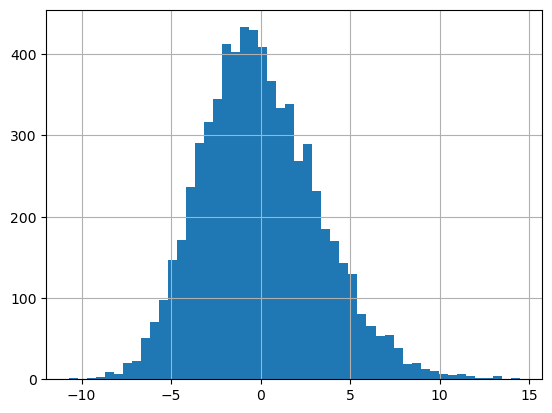

In [520]:

#Evaluate OLS normality assumptions
#Calculate residuals

slm_residuals = y_train - slm_predictions

#Check model normality
jb = jarque_bera(slm_residuals)
nt = normaltest(slm_residuals)

print('The mean of the residuals is: ',np.mean(slm_residuals))
print('This is their JB test result -->','\'statistic\' :', jb[0],'\'p-value\' :',jb[1])
print('This is their Normaltest result -->','\'statistic\' :', nt[0],'\'p-value\' :',nt[1])

slm_residuals.hist(bins=50);
#----------------------------------------------------

The model suffices two fundamental assumptions in the linear model:
1. The mean of $e$ (the error term) is cero, and
2. There is no multicorrelation of the error terms (the Durbin Watson test in 2)

The model has multicolinearity problems due to the number of features used. We will use a Ridge regularization method to work around this problem.

In [ ]:

# Instantiate Pipeline with Polynomial Features and Random Forest Classifier
pipeline = Pipeline([
    ('poly', PolynomialFeatures(interaction_only=True)),
    ('clf', RandomForestClassifier())
])

# Define parameters for Grid Search
param_grid = {
    'poly__degree': [1],
    'clf__n_estimators': [100, 200],
    #'clf__max_features': ['auto', 'sqrt', 'log2'],
    'clf__max_depth': [None, 10, 20, 30],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4],
    #'clf__bootstrap': [True, False],
    'clf__class_weight': [None, 'balanced'],
    #'clf__min_impurity_decrease': [0.0, 0.1, 0.01],
    'clf__max_leaf_nodes': [None, 50, 100, 200]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, verbose=1, n_jobs=-1)
grid_search.fit(Xs_train, y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


C:\Users\roflo\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [540]:
#Improve regression with Ridge Regularization, Standarizing Data, and Polynomial Features
#Using Grid Search

#Instantiate Pipeline
pipeline = Pipeline([
    ('poly',PolynomialFeatures()),
    ('model',Ridge())
])

#Define parameters, if only one parameter is set in the pipeline it corresponds to the optimized parameters found in our analysis
params = {
    'poly__degree':[2],
    'poly__interaction_only':[True],
    'model__alpha': [3488],
    'model__fit_intercept':[True]
}

#Instantiate Grid Search
gs = GridSearchCV(pipeline, params, cv=5)
gs.fit(Xs_train, y_train)

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\roflo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\roflo\anaconda3\lib\site-packages\sklearn\pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\roflo\anaconda3\lib\site-packages\sklearn\pipeline.py", line 359, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\roflo\anaconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\roflo\anaconda3\lib\site-packages\sklearn\pipeline.py", line 893, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "C:\Users\roflo\anaconda3\lib\site-packages\sklearn\utils\_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "C:\Users\roflo\anaconda3\lib\site-packages\sklearn\base.py", line 862, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
  File "C:\Users\roflo\anaconda3\lib\site-packages\sklearn\utils\_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "C:\Users\roflo\anaconda3\lib\site-packages\sklearn\preprocessing\_polynomial.py", line 393, in transform
    XP = np.empty(
numpy.core._exceptions._ArrayMemoryError: Unable to allocate 1.81 GiB for an array with shape (5376, 45151) and data type float64


In [530]:
#Check best score
gs.best_score_

0.1912252107583136

In [531]:
#Check
gs.best_params_

{'model__alpha': 0.1, 'reduce_dim__n_components': 15}

In [532]:
#Score in Train
gs.score(Xs_train,y_train)

0.19588125282831292

In [533]:
#Score in Test
gs.score(Xs_test,y_test)

0.17496297667647065

In [534]:

#Visualize position and predictions in a dataframe

#Rename predictions series and join series into dataframe
slm_ridge_predictions = pd.Series(gs.predict(Xs_train))
slm_ridge_predictions.name = 'predictions'            #Name series
slm_ridge_predictions.index = y_train.index           #Re-index
df_slm_ridge_results = y_train.to_frame().join(slm_ridge_predictions)

#Round results
df_slm_ridge_results['predictions'] = df_slm_ridge_results['predictions'].round().apply(lambda x : 0 if x <= 0 else x)

#Preview results for training set
df_slm_ridge_results.head()
#----------------------------------------------------

,position,predictions
1769,12.0,10.0
906,8.0,7.0
1725,15.0,9.0
7031,14.0,4.0
5578,16.0,12.0


In [535]:
#NOTE - move to package!
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
def classification_results(y_true, y_pred, method = 'micro'):

    # Compute classification statistics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average=method)  
    recall = recall_score(y_true, y_pred, average=method)        
    f1 = f1_score(y_true, y_pred, average=method)                

    # Print the classification statistics
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")


In [536]:
classification_results(df_slm_ridge_results['position'],df_slm_ridge_results['predictions'])

Accuracy: 0.0693452380952381
Precision: 0.0693452380952381
Recall: 0.0693452380952381
F1 Score: 0.0693452380952381


In [537]:
#Now for Testing Set

#Rename predictions series and join series into dataframe
slm_ridge_predictions = pd.Series(gs.predict(Xs_test))
slm_ridge_predictions.name = 'predictions'            #Name series
slm_ridge_predictions.index = y_test.index           #Re-index
df_slm_ridge_results = y_test.to_frame().join(slm_ridge_predictions)

#Round results
df_slm_ridge_results['predictions'] = df_slm_ridge_results['predictions'].round().apply(lambda x : 0 if x <= 0 else x)

#Preview results for training set
df_slm_ridge_results.head()
#----------------------------------------------------

,position,predictions
7660,9.0,6.0
1074,1.0,8.0
7121,11.0,6.0
6807,1.0,3.0
3784,13.0,8.0


In [538]:
classification_results(df_slm_ridge_results['position'],df_slm_ridge_results['predictions'])

Accuracy: 0.06111111111111111
Precision: 0.06111111111111111
Recall: 0.06111111111111111
F1 Score: 0.06111111111111111


In [539]:
# Compute the confusion matrix
cm = confusion_matrix(df_slm_ridge_results['position'],df_slm_ridge_results['predictions'])
print("Confusion Matrix:")
pd.DataFrame(cm)

Confusion Matrix:


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0,1,8,42,86,99,118,93,60,52,...,3,1,0,0,0,0,0,0,0,0
1,0,8,11,25,17,30,20,10,3,3,...,0,0,0,0,0,0,0,0,0,0
2,0,3,4,13,23,30,18,16,6,4,...,0,0,0,0,0,0,0,0,0,0
3,0,0,2,15,15,27,27,13,8,6,...,0,0,0,0,0,0,0,0,0,0
4,0,0,3,10,12,33,17,22,7,7,...,0,0,0,0,0,0,0,0,0,0
5,0,1,1,8,21,23,23,18,20,8,...,1,0,0,0,0,0,0,0,0,0
6,0,0,3,8,14,22,21,18,23,11,...,0,0,0,0,0,0,0,0,0,0
7,0,0,1,5,17,20,25,19,23,12,...,0,0,0,0,0,0,0,0,0,0
8,0,0,2,2,14,20,15,14,31,19,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,1,6,11,34,22,23,18,...,0,0,0,0,0,0,0,0,0,0
